# Análises adicionais para o paper IEEE Access

Objetivo: ampliar os resultados da submissão pro IEEE PES GM2021, a partir dos comentários recebidos dos revisores, extraindo as seguintes métricas:

- Avaliar DLAFE  treinado na casa 3 quando aplicada nas demais casas similares , para cada um dos aparelhos -> (objetivo: checar generalização "superficial" - sem retreino do extrator/classificador)
- Avaliar desempenho em aparelhos complexos, baseado em 3 categorias: longo tempo de transitório de ativação / alta flutuação de operação / aparelhos com sobreposição de transitórios (INVIÁVEL POR EQTO)
- Avaliar o impacto da janela para cada aparelho, de acordo c seu modo de operação (especialmente dishwasher)

E se der tempo...
- Fine-tuning do extrator + classificador, e avaliar generalização real entre as casas similares.

# Configurações

In [1]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
from six import iteritems

%matplotlib inline

In [2]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

from tqdm import *

from pretty_confusion_matrix import *

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

# Dados

In [3]:
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

## Base REDD

In [4]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS
RESIDENCIA = 3

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "25") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")

# Path completo do arquivo REDD
arquivo_dataset = os.path.join(caminho_redd, "redd.h5")

# VARIAVEL AUXILIAR
# Path dos arquivos relacionados as janelas
caminho_janelas = os.path.join(caminho_redd, "../../phd")
if not os.path.isdir(caminho_janelas):
    os.makedirs(caminho_janelas)

In [5]:
# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset):
    from nilmtk.dataset_converters import convert_redd
    
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset)

# Carregando dataset REDD no objeto NILMTK
# Exemplo de carregamento da base REDD no NILMTK
import h5py # * Evitar erro de incompatibilidade entre h5py e nilmtk
from nilmtk import DataSet
from nilmtk.utils import print_dict
redd = DataSet(arquivo_dataset)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)
print()


NILMTK -> Detalhes sobre o dataset REDD:


## Configurações do Experimento

In [6]:
# Parametros dos dados
PARAMETROS_DATASET_GERAL = {
    "base":redd,
    "id_residencia": RESIDENCIA,
    "inicio_intervalo": '2011-04-16', # 01:11:27',
    "fim_intervalo": '2011-05-30',    # 20:19:54',
    "debug": False    
}

# Dados de treino
PARAMETROS_DATASET_TREINO = {
    "base":redd,
    "id_residencia": RESIDENCIA,
    "inicio_intervalo": '2011-04-16', #, # MUDANCA
    "fim_intervalo": '2011-05-16', #'2011-05-30 20:19:54', #,
    "debug": False    
}

# Dados de teste
PARAMETROS_DATASET_TESTE = {
    "base":redd,
    "id_residencia": RESIDENCIA,
    "inicio_intervalo": '2011-05-17', #, # MUDANCA
    "fim_intervalo": '2011-05-30', #'2011-05-30 20:19:54', #,
    "debug": False    
}

## Análise Exploratória

In [ ]:
casa = redd.buildings[3]

fig = plt.figure(figsize=(20,8))
ax = casa.elec.plot()
ax.set_xticks(list(set(next(casa.elec[1].load()).index.map(str).map(lambda x: x.split(' ')[0]))))
plt.title('Full REDD dataset - House #3');
plt.show()

In [ ]:
redd.set_window(
    start=PARAMETROS_DATASET_TREINO["inicio_intervalo"],
    end=PARAMETROS_DATASET_TREINO["fim_intervalo"]
)
casa = redd.buildings[3]

fig = plt.figure(figsize=(20,8))
ax = casa.elec.plot()
ax.set_xticks(list(set(next(casa.elec[1].load()).index.map(str).map(lambda x: x.split(' ')[0]))))
plt.title('Train REDD dataset - House #3');
plt.show()

In [ ]:
redd.set_window(
    start=PARAMETROS_DATASET_TESTE["inicio_intervalo"],
    end=PARAMETROS_DATASET_TESTE["fim_intervalo"]
)
casa = redd.buildings[3]

fig = plt.figure(figsize=(20,8))
ax = casa.elec.plot()
ax.set_xticks(list(set(next(casa.elec[1].load()).index.map(str).map(lambda x: x.split(' ')[0]))))
plt.title('Test REDD dataset - House #3');
plt.show()

In [ ]:


# Tipos de atributos
print("ATRIBUTOS DISPONÍVEIS POR REGISTRO:\n")
for e in casa.elec.all_meters():
    if type(e) == nilmtk.elecmeter.ElecMeter:
        print(f"{e.label()}: {e.available_columns()}")
    else:
        for e_ in e.all_meters():
            print(f" - {e_.label()}: {e_.available_columns()}")

In [ ]:
mains_1 = next(casa.elec[1].load())
mains_1

In [ ]:
mains_2 = next(casa.elec[2].load())
mains_2

In [ ]:
next(casa.elec[1].when_on(on_power_threshold=10)) 

In [ ]:
redd.set_window(
    start=PARAMETROS_DATASET["inicio_intervalo"],
    end=PARAMETROS_DATASET["fim_intervalo"]
)
next(casa.elec[1].when_on(on_power_threshold=10)) 

In [ ]:
# import plotly.express as px


# for e in redd.buildings[3].elec.meters:
#     activations = e.activation_series()
#     if len(activations) > 0:
#         df_activations = pd.concat(activations, axis=1)
#         df_activations.columns = [f'Activation #{a+1}' for a in range(len(activations))]

#         fig = px.line(df_activations, title=f'{e.label()} - {e.instance()}')
#         fig.show()
#     else:
#         fig = plt.figure()
#         e.plot()
#         plt.show()

In [ ]:
from pyts.image import RecurrencePlot

# Parametros RP (verificado empiricamente)
# 
# Taken’s embedding theorem (1980)
D = 5
m = 2#2 * D + 1
t = 1
PARAMETROS_RP = {
    "dimension": m,
    "time_delay": 1,
    "threshold": 'point',
    "percentage": 50
}

activations = redd.buildings[3].elec.meters[16].activation_series()

rps = []
for i,a in enumerate(activations):
    serie_original = a.values
    rp_original = RecurrencePlot(**PARAMETROS_RP).fit_transform([serie_original])[0]
    serie_norm = serie_original / serie_original.max()
    rp_norm = RecurrencePlot(**PARAMETROS_RP).fit_transform([serie_norm])[0]

    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(range(len(serie_original)), serie_original)
    axs[0, 0].set_title('Serie Original')
    axs[0, 1].imshow(rp_original, cmap='binary', origin='lower')
    axs[0, 1].set_title('RP')
    axs[1, 0].plot(range(len(serie_norm)), serie_norm)
    axs[1, 0].set_title('Serie Norm.')
    axs[1, 1].imshow(rp_norm, cmap='binary', origin='lower')
    axs[1, 1].set_title('RP')
    plt.tight_layout()
    plt.suptitle(f'Amostra #{i}')
    fig.show()
    

In [ ]:
del casa

## Melhores Combinações de Taxas e Janelas para cada Aparelho (estudo 19)

In [7]:
df_melhores_taxas_janelas = pd.read_csv(os.path.join(caminho_dados, "19", "melhores_taxa_janela_aparelhos.csv"), index_col=0)
df_melhores_taxas_janelas

,carga,taxa_amostragem,janela,loss,acuracia,precisao,recall,f1,f1_macro
0,dish_washer - 9,2,720,0.05,95.33,20.00,25.00,22.22,59.91
1,fridge - 7,2,1080,0.00,100.00,100.00,100.00,100.00,100.00
2,microwave - 16,2,900,0.04,95.83,66.67,33.33,44.44,71.14
3,washer_dryer - 13,2,60,0.00,99.89,100.00,95.74,97.83,98.88
4,washer_dryer - 14,3,360,0.02,97.99,100.00,55.56,71.43,85.19


In [8]:
# TODO: 
# - Desenvolver módulo da metodologia na lib PyNILM

## Parâmetros de RP dos Aparelhos (estudo 18)

In [9]:
# Carregando arquivos de parametros, caso n estejam (kernel reiniciado)
import json
if not 'parametros_rp_aparelho' in locals():
    with open(os.path.join(caminho_dados, "18", "parametros_rp_aparelho.json"),'r') as arquivo:
        parametros_rp_aparelho = json.load(arquivo)

# Funções Auxiliares

In [10]:
# from PyNILM.dados.janelas import Janelas
from PyNILM.dados.janelas import Janelas
from PyNILM.dados.utils import *

from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from PyNILM.modelos.dlafe import DLAFE

# TODO: Mover funcoes tensorflow para modelos.utils

In [11]:
import tensorflow as tf
from tensorflow.keras import applications as transfer_learning
from tensorflow.keras.models import Model
from sklearn.base import clone

def start_tf_session(memory_limit=int(1024*4)):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
        try:
            tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print("Inicializando sessão com", len(gpus), "GPUs Físicas /", len(logical_gpus), "GPUs Lógicas")
        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)
    else:
        print("Nenhuma GPU disponível ou encontrada")

start_tf_session()

Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas


In [12]:
# Reset Keras Session
def reset_tf_session(model_name):
    
    print("* Reinicializando sessão tensorflow...")
    tf.keras.backend.clear_session()

    try:
        del globals()[model_name] # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted
    
    try:
        start_tf_session()
    except:
        pass

# reset_tf_session(model_name='dlafe')

# Resultados Paper IEEE Access

In [13]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

resultados = []

In [ ]:
modelos = {
    'dish_washer - 9': SVC(kernel='rbf', random_state=SEED),
    'fridge - 7': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'microwave - 16': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'washer_dryer - 13': SVC(kernel='rbf', random_state=SEED),
    'washer_dryer - 14': SVC(kernel='rbf', random_state=SEED)
}

resultados_modelo = {
    "appliance": [], "fold": [],
    "acc": [], "f1": [], "auc": []
}

for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16']),
    : ]["carga"].values:
    
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])
    
    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAMANHO_JANELA = config_aparelho["janela"]
    TAXA = config_aparelho["taxa_amostragem"]
    
    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()
    
    y_true, y_pred  = [], []

    print("   - Evaluation model (CV - 10 folds)...\n")
    for it, (idx_treino, idx_teste) in enumerate(skf.split(X, y)):

        # Preparando lotes
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]

        # Treinando modelo
        dlafe = DLAFE(
            feature_extractor = transfer_learning.vgg16.VGG16(
                input_shape=TAMANHO_IMAGEM,
                weights='imagenet', 
                include_top=False,
                pooling='avg'
            ),
            preprocess_input = transfer_learning.vgg16.preprocess_input,
            classifier = clone(modelos[rotulo_aparelho]),
            rp_params = PARAMETROS_RP,
            input_shape = TAMANHO_IMAGEM,
            normalize=True
        )
        dlafe.fit(X_treino, y_treino)

        # Prevendo conjunto de teste
        y_hat = dlafe.predict(X_teste)

        # Incrementando resultados
        resultados_modelo["appliance"].append(rotulo_aparelho)
        resultados_modelo["fold"].append(it+1)
        resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
        resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
        resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)

        # Extendendo rotulos (analise global)
        y_true.extend(y_teste)
        y_pred.extend(y_hat)

    print()
    print("   - Final Results:")
    print("   ---")
    print()

    print("      -> Classification Report:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Confusion Matrix:")
    print()
    print(confusion_matrix(y_true, y_pred))

    print()
    

    
    

#### Avaliação do pipeline de geração de amostras RP

In [ ]:
# Exemplo - aparelho Microondas
X, y = carregar_dados_aparelho(
    janelas=janelas,
    instancia=16,
    aparelho='microwave',
    tamanho_janela=180,
    taxa=8,
    eliminar_janelas_vazias=True
)

idx_exemplo = 7
plt.plot(np.arange(180), X[idx_exemplo,:])
plt.title(f'Amostra Microondas (status = {y[idx_exemplo]})')
plt.show()

In [ ]:
# Transformação da serie em RP - via DLAFE
dlafe = DLAFE(
    rp_params={
        "dimension": 1,
        "time_delay": 1,
        "threshold": None,
        "percentage": 10
    },
    input_shape=TAMANHO_IMAGEM, 
    data_type=np.float32,
    normalize=False, 
    standardize=False, 
    rescale=True
)

rp_exemplo = dlafe.seq_to_rp([X[idx_exemplo,:]])[0]

print('RP DLAFE:', rp_exemplo.shape, '|', type(rp_exemplo), '|', rp_exemplo.dtype,'\n')

for i in range(rp_exemplo.shape[-1]):
    print(f'Canal #{i+1}:')
    fig = plt.figure(figsize=(5,5))
    plt.imshow(rp_exemplo[:,:,i], aspect='auto')
    plt.axis('off')
    plt.grid(False)
    plt.show()
    fig.savefig(
        os.path.join(caminho_imagens_notebook, f'rp_exemplo_canal-{i+1}.png'), 
                bbox_inches='tight', pad_inches=0)
    
    print('Min:',rp_exemplo.min(),
          '| Max: ', rp_exemplo.max(),
          '\nMean: ', rp_exemplo.mean(),
          '| Std: ', rp_exemplo.std(),
         )
    print('\n','='*40,'\n')

In [ ]:

rp_disco = cv2.imread(os.path.join(caminho_imagens_notebook, f'rp_exemplo_canal-1.png'))

print('RP DISCO:', rp_disco.shape, '|', type(rp_disco), '|', rp_disco.dtype,'\n')

for i in range(rp_disco.shape[-1]):
    print(f'Canal #{i+1}:')
    fig = plt.figure(figsize=(5,5))
    plt.imshow(rp_disco[:,:,i], aspect='auto')
    plt.axis('off')
    plt.grid(False)
    plt.show()
    fig.savefig(
        os.path.join(caminho_imagens_notebook, f'rp_disco_canal-{i+1}.png'), 
                bbox_inches='tight', pad_inches=0)
    
    print('Min:',rp_disco.min(),
          '| Max: ', rp_disco.max(),
          '\nMean: ', rp_disco.mean(),
          '| Std: ', rp_disco.std(),
         )
    print('\n','='*40,'\n')

In [ ]:
from PIL import Image

# rp_pillow = Image.fromarray((rp_exemplo * 255).astype(int), 'RGB')
rp_pillow = Image.fromarray(np.uint8(rp_exemplo*255),'RGB')
# rp_pillow.show()
rp_pillow = np.asarray(rp_pillow)

print('RP PILLOW:', rp_pillow.shape, '|', rp_pillow.dtype,'\n')

for i in range(rp_pillow.shape[-1]):
    print(f'Canal #{i+1}:')
    fig = plt.figure(figsize=(5,5))
    plt.imshow(rp_pillow[:,:,i], aspect='auto')
    plt.axis('off')
    plt.grid(False)
    plt.show()
    fig.savefig(
        os.path.join(caminho_imagens_notebook, f'rp_pillow_canal-{i+1}.png'), 
                bbox_inches='tight', pad_inches=0)
    
    print('Min:',rp_pillow.min(),
          '| Max: ', rp_pillow.max(),
          '\nMean: ', rp_pillow.mean(),
          '| Std: ', rp_pillow.std(),
         )
    print('\n','='*40,'\n')

In [ ]:
from matplotlib import cm
im = Image.fromarray(np.uint8((rp_exemplo)*255),'RGB')
plt.imshow(np.asarray(im)[:,:,0])

#### Treinamento com base ampla (registro histórico completo)
---
Alternativa frente ao uso de apenas dado semanal apresentado nos estudos realizados até aqui, o qual estabeleu os resuintes resultados.

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.base import clone

persistir = False

modelos = {
    'dish_washer - 9': SVC(kernel='rbf', random_state=SEED),
    'fridge - 7': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'microwave - 16': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'washer_dryer - 13': SVC(kernel='rbf', random_state=SEED),
    'washer_dryer - 14': SVC(kernel='rbf', random_state=SEED)
}

resultados_modelo = {
    "appliance": [], "fold": [],
    "acc": [], "f1": [], "auc": []
}

for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = PARAMETROS_RP
    
    # Percorrer instancias do aparelho na residencia
#     for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):
        
    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    print("   - Detalhes da amostragem (lotes):")
    print("   ---")
    for item in Counter(y).items():
        print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()

    print("* Convertendo séries para RPs...")
    #rqa.extend( preparar_amostras(X, y, rotulo_aparelho) )
    X, y = preparar_amostras(
        X, y, 
        params_rp=PARAMETROS_RP,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    #print(X.shape)

    if persistir:
        print("* Persistindo dados...")
        np.save(os.path.join(
            caminho_dados_notebook, 
            rotulo_aparelho.lower().replace(" ", "_"),
        )+"_X.npy", X) 
        np.save(os.path.join(
            caminho_dados_notebook, 
            rotulo_aparelho.lower().replace(" ", "_"),
        )+"_y.npy", y) 
        print()

    # Extrair atributos usando Deep/Tranfer Learning
    X = extrair_atributos_dl(
        X, 
        modelo=modelo_extrator,
        preprocessamento=preprocess_extrator
    )

    y_true, y_pred  = [], []

    print("   - Evaluation model (CV - 10 folds)...\n")
    for it, (idx_treino, idx_teste) in enumerate(skf.split(X, y)):

        # Preparando lotes
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]

        # Treinando modelo
#         modelo = XGBClassifier(random_state=SEED, n_jobs=4) #
        modelo = clone(modelos[rotulo_aparelho])
        modelo.fit(X_treino, y_treino)#, sample_weight=compute_sample_weight("balanced", y_treino))

        # Prevendo conjunto de teste
        y_hat = modelo.predict(X_teste)

        # Incrementando resultados
        resultados_modelo["appliance"].append(rotulo_aparelho)
        resultados_modelo["fold"].append(it+1)
        resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
        resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
        resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)

        # Extendendo rotulos (analise global)
        y_true.extend(y_teste)
        y_pred.extend(y_hat)

    print()
    print("   - Final Results:")
    print("   ---")
    print()

    print("      -> Classification Report:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Confusion Matrix:")
    print()
    print(confusion_matrix(y_true, y_pred))

    print()

In [ ]:
# Consolidating DataFrame
resultados_completo = pd.DataFrame(resultados_modelo)
resultados_completo.to_excel(os.path.join(caminho_dados_notebook, "resultados_dataset_completo_xgb.xlsx"))
    
print("############################## RESULTADOS DATASET COMPLETO ##############################")
display(resultados_completo.groupby("appliance").agg({
    "acc": ["mean", "std", "max", "min"],
    "f1": ["mean", "std", "max", "min"],
    "auc": ["mean", "std", "max", "min"]
}))

#### Taxa Amostragem Fixa
---

Baseado em `Improving Non-Intrusive Load Disaggregation through an Attention-Based Deep Neural Network`.

In [ ]:
from sklearn.base import clone

persistir = False

modelos = {
    'dish_washer - 9': SVC(kernel='rbf', random_state=SEED),
    'fridge - 7': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'microwave - 16': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'washer_dryer - 13': SVC(kernel='rbf', random_state=SEED),
    'washer_dryer - 14': SVC(kernel='rbf', random_state=SEED)
}



resultados_modelo = {
    "appliance": [], "fold": [],
    "acc": [], "f1": [], "auc": []
}


##########################################
config_aparelho = {
    'dish_washer': {
        'janela': 2304,
        'taxa': 1
    },
    'fridge': {
        'janela': 496,
        'taxa': 1
    },
    'microwave':{
        'janela': 128,
        'taxa': 1
    },
}
##########################################

TAMANHO_IMAGEM = (32,32,3)

modelo_extrator = transfer_learning.vgg16.VGG16(
            input_shape=TAMANHO_IMAGEM,
            weights='imagenet', 
            include_top=False,
            pooling='avg'
        )
preprocess_extrator = transfer_learning.vgg16.preprocess_input


for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16']),
    : ]["carga"].values:
    
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    TAMANHO_JANELA = config_aparelho[CARGA]["janela"]
    TAXA = config_aparelho[CARGA]["taxa"]
    CONFIG_RP_APARELHO = PARAMETROS_RP
    
    # Percorrer instancias do aparelho na residencia
#     for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):
        
    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    print("   - Detalhes da amostragem (lotes):")
    print("   ---")
    for item in Counter(y).items():
        print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()

    print("* Convertendo séries para RPs...")
    #rqa.extend( preparar_amostras(X, y, rotulo_aparelho) )
    X, y = preparar_amostras(
        X, y, 
        params_rp=PARAMETROS_RP,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    #print(X.shape)

    if persistir:
        print("* Persistindo dados...")
        np.save(os.path.join(
            caminho_dados_notebook, 
            rotulo_aparelho.lower().replace(" ", "_"),
        )+"_X.npy", X) 
        np.save(os.path.join(
            caminho_dados_notebook, 
            rotulo_aparelho.lower().replace(" ", "_"),
        )+"_y.npy", y) 
        print()

    # Extrair atributos usando Deep/Tranfer Learning
    X = extrair_atributos_dl(
        X, 
        modelo=modelo_extrator,
        preprocessamento=preprocess_extrator
    )

    y_true, y_pred  = [], []

    print("   - Evaluation model (CV - 10 folds)...\n")
    for it, (idx_treino, idx_teste) in enumerate(skf.split(X, y)):

        # Preparando lotes
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]

        # Treinando modelo
#         modelo = XGBClassifier(random_state=SEED, n_jobs=4) #
        modelo = clone(modelos[rotulo_aparelho])
        modelo.fit(X_treino, y_treino)#, sample_weight=compute_sample_weight("balanced", y_treino))

        # Prevendo conjunto de teste
        y_hat = modelo.predict(X_teste)

        # Incrementando resultados
        resultados_modelo["appliance"].append(rotulo_aparelho)
        resultados_modelo["fold"].append(it+1)
        resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
        resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
        resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)

        # Extendendo rotulos (analise global)
        y_true.extend(y_teste)
        y_pred.extend(y_hat)

    print()
    print("   - Final Results:")
    print("   ---")
    print()

    print("      -> Classification Report:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Confusion Matrix:")
    print()
    print(confusion_matrix(y_true, y_pred))

    print()

In [ ]:
# Consolidating DataFrame
resultados = pd.DataFrame(resultados_modelo)
# resultados.to_excel(os.path.join(caminho_dados_notebook, "resultados_taxa_janela_paper.xlsx"))
    
print("############################## RESULTADOS DATASET COMPLETO ##############################")
display(resultados.groupby("appliance").agg({
    "acc": ["mean", "std", "max", "min"],
    "f1": ["mean", "std", "max", "min"],
    "auc": ["mean", "std", "max", "min"]
}))

#### Transfer Learning

In [ ]:
import tensorflow as tf

persistir = False

modelos = {
    'dish_washer - 9': SVC(kernel='rbf', random_state=SEED),
    'fridge - 7': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'microwave - 16': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'washer_dryer - 13': SVC(kernel='rbf', random_state=SEED),
    'washer_dryer - 14': SVC(kernel='rbf', random_state=SEED)
}



resultados_modelo = {
    "appliance": [], "fold": [],
    "acc": [], "f1": [], "auc": []
}


##########################################
config_aparelho = {
    'dish_washer': {
        'janela': 2304,
        'taxa': 1
    },
    'fridge': {
        'janela': 496,
        'taxa': 1
    },
    'microwave':{
        'janela': 128,
        'taxa': 1
    },
}
##########################################

TAMANHO_IMAGEM = (32,32,3)

modelo_extrator = transfer_learning.vgg16.VGG16(
            input_shape=TAMANHO_IMAGEM,
            weights='imagenet', 
            include_top=False,
            pooling='avg'
        )
preprocess_extrator = transfer_learning.vgg16.preprocess_input


for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16']),
    : ]["carga"].values:
    
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    TAMANHO_JANELA = config_aparelho[CARGA]["janela"]
    TAXA = config_aparelho[CARGA]["taxa"]
    CONFIG_RP_APARELHO = PARAMETROS_RP
    
    # Percorrer instancias do aparelho na residencia
#     for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):
        
    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    print("   - Detalhes da amostragem (lotes):")
    print("   ---")
    for item in Counter(y).items():
        print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()

    print("* Convertendo séries para RPs...")
    #rqa.extend( preparar_amostras(X, y, rotulo_aparelho) )
    X, y = preparar_amostras(
        X, y, 
        params_rp=PARAMETROS_RP,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    #print(X.shape)

    if persistir:
        print("* Persistindo dados...")
        np.save(os.path.join(
            caminho_dados_notebook, 
            rotulo_aparelho.lower().replace(" ", "_"),
        )+"_X.npy", X) 
        np.save(os.path.join(
            caminho_dados_notebook, 
            rotulo_aparelho.lower().replace(" ", "_"),
        )+"_y.npy", y) 
        print()

    X = transfer_learning.vgg16.preprocess_input(X)

#     # Extrair atributos usando Deep/Tranfer Learning
#     X = extrair_atributos_dl(
#         X, 
#         modelo=modelo_extrator,
#         preprocessamento=preprocess_extrator
#     )

    y_true, y_pred  = [], []

    print("   - Evaluation model (CV - 10 folds)...\n")
    for it, (idx_treino, idx_teste) in enumerate(skf.split(X, y)):

        # Preparando lotes
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]

#         # Treinando modelo
# #         modelo = XGBClassifier(random_state=SEED, n_jobs=4) #
#         modelo = clone(modelos[rotulo_aparelho])
#         modelo.fit(X_treino, y_treino)#, sample_weight=compute_sample_weight("balanced", y_treino))
        # Ajuste fino do modelo
        base_model = transfer_learning.vgg16.VGG16(
                    input_shape=TAMANHO_IMAGEM,
                    weights='imagenet', 
                    include_top=False,
                    pooling='avg'
                )
        base_model.trainable = False
        inputs = tf.keras.Input(shape=TAMANHO_IMAGEM)
        # We make sure that the base_model is running in inference mode here,
        # by passing `training=False`. This is important for fine-tuning, as you will
        # learn in a few paragraphs.
        x = base_model(inputs, training=False)
        # Convert features of shape `base_model.output_shape[1:]` to vectors
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        # A Dense classifier with a single unit (binary classification)
        outputs = tf.keras.layers.Dense(1)(x)
        modelo = tf.keras.Model(inputs, outputs)
        modelo.compile(optimizer=keras.optimizers.Adam(),
                      loss=keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=[keras.metrics.BinaryAccuracy()])
        modelo.fit((X_treino, y_treino), epochs=20)

        
        preprocess_extrator = transfer_learning.vgg16.preprocess_input
        


        # Prevendo conjunto de teste
        y_hat = modelo.predict(X_teste)

        # Incrementando resultados
        resultados_modelo["appliance"].append(rotulo_aparelho)
        resultados_modelo["fold"].append(it+1)
        resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
        resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
        resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)

        # Extendendo rotulos (analise global)
        y_true.extend(y_teste)
        y_pred.extend(y_hat)

    print()
    print("   - Final Results:")
    print("   ---")
    print()

    print("      -> Classification Report:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Confusion Matrix:")
    print()
    print(confusion_matrix(y_true, y_pred))

    print()

## Treino via classe DLAFE (Dados treino/teste - Resid. 3)

In [ ]:

# # Dados 'janelados'
# janelas_treino = Janelas(
#     base=redd,
#     id_residencia=3,
#     inicio_intervalo='2011-04-16',
#     fim_intervalo='2011-05-16',
#     debug = False
# )

# janelas_teste = Janelas(
#     base=redd,
#     id_residencia=3,
#     inicio_intervalo='2011-05-17',
#     fim_intervalo='2011-05-30',
#     debug = False
# )

In [ ]:
# Modelos de classificacao adotados - com base no estudo 24
modelos = {
    'dish_washer - 9': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'fridge - 7': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'microwave - 16': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'washer_dryer - 13': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'washer_dryer - 14': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
}

resultados_modelo = {
    "appliance": [], "fold": [],
    "acc": [], "f1": [], "auc": [], 
    "base": []
}

# Carregando dados de treino/teste
janelas_treino = Janelas(**PARAMETROS_DATASET_TREINO)
janelas_teste = Janelas(**PARAMETROS_DATASET_TESTE)

# Processamento de cada aparelho
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        [
            'dish_washer - 9','fridge - 7','microwave - 16',
            'washer_dryer - 13', 'washer_dryer - 14'
        ]),
    : ]["carga"].values:
    
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])
    
    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAMANHO_JANELA = config_aparelho["janela"]
    TAXA = config_aparelho["taxa_amostragem"]
    
    #######################################################################
    #                AVALIACAO 1 - Base de treino / CV                    #
    #######################################################################
    # Extrair series divididas em janelas para cada medidor
    print("   - Base de TREINO\n")
    print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas_treino,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print("     -> Detalhes da amostragem (lotes):")
    print("     ---")
    for item in Counter(y).items():
        print(f"        - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()
    
    y_true, y_pred  = [], []

    print(f"     -> Avaliando modelo (CV - {skf.n_splits} folds)...\n")
    for it, (idx_treino, idx_teste) in tqdm_notebook(enumerate(skf.split(X, y)), total=skf.n_splits):

        # Preparando lotes
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]

        # Treinando modelo
        dlafe = DLAFE(
            feature_extractor = transfer_learning.vgg16.VGG16(
                input_shape=TAMANHO_IMAGEM_DLAFE,
                weights='imagenet', 
                include_top=False,
                pooling='avg'
            ),
            preprocess_input = transfer_learning.vgg16.preprocess_input,
            classifier = clone(modelos[rotulo_aparelho]),
            rp_params = PARAMETROS_RP,
            input_shape = TAMANHO_IMAGEM_DLAFE,
            normalize=False
        )
        dlafe.fit(X_treino, y_treino)

        # Prevendo conjunto de teste
        y_hat = dlafe.predict(X_teste)

        # Incrementando resultados
        resultados_modelo["appliance"].append(rotulo_aparelho)
        resultados_modelo["fold"].append(it+1)
        resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
        resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
        resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)
        resultados_modelo["base"].append("treino")

        # Extendendo rotulos (analise global)
        y_true.extend(y_teste)
        y_pred.extend(y_hat)
        
#         print(f"       _ Classification Report fold #{it}:")
#         print()
#         print(classification_report(y_teste, y_hat))

    #######################################################################
    #                 AVALIACAO 2 - Base de teste / CV                    #
    #######################################################################
    print("   - Base de TESTE\n")
    print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))

    # Avaliar na base de teste
    X_teste, y_teste = carregar_dados_aparelho(
        janelas=janelas_teste,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    
    print("     -> Detalhes da amostragem (lotes):")
    print("     ---")
    for item in Counter(y_teste).items():
        print(f"       - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()

    
    # Treinando modelo
    dlafe = DLAFE(
        feature_extractor = transfer_learning.vgg16.VGG16(
            input_shape=TAMANHO_IMAGEM_DLAFE,
            weights='imagenet', 
            include_top=False,
            pooling='avg'
        ),
        preprocess_input = transfer_learning.vgg16.preprocess_input,
        classifier = clone(modelos[rotulo_aparelho]),
        rp_params = PARAMETROS_RP,
        input_shape = TAMANHO_IMAGEM_DLAFE,
        normalize=False
    )
    dlafe.fit(X, y)

    # Prevendo conjunto de teste
    y_hat = dlafe.predict(X_teste)

    # Incrementando resultados
    resultados_modelo["appliance"].append(rotulo_aparelho)
    resultados_modelo["fold"].append(it+1)
    resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
    resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
    resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)
    resultados_modelo["base"].append("teste")
    
    print()
    print("   - Final Results:")
    print("   ---")
    print()

    print("      -> Classification Report:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Confusion Matrix:")
    print()
    print(confusion_matrix(y_true, y_pred))

    print()
    
# Consolidating DataFrame
df_resultados_dlafe = pd.DataFrame(resultados_modelo)
df_resultados_dlafe.to_excel(os.path.join(caminho_dados_notebook, "df_resultados_dlafe.xlsx"))
    
print("############################## FINAL MODEL RESULTS ##############################")
display(df_resultados_dlafe.groupby(["appliance","base"]).agg({
    "acc": ["mean", "std", "max", "min"],
    "f1": ["mean", "std", "max", "min"],
    "auc": ["mean", "std", "max", "min"]
}))

## Generalização "superficial" 

Avaliar proposta quando usado para inferência em demais casas (sem retreino).

In [ ]:
# Avaliar em cada uma das casas similares ao estudo (3)
# Dishwasher     - Casas 1, 2, 4, 5, 6
# Fridge         - Casas 1, 2,    5, 6
# Microwave      - Casas 1, 2,    5
# Washer Dryer 1 - Casas 1, 2, 4, 5, 6 
# Washer Dryer 2 - Casas 1, 2, 4, 5, 6

modelos_generalizacao = {
    'dish_washer - 9': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'fridge - 7': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'microwave - 16': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'washer_dryer - 13': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'washer_dryer - 14': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED)
}

resultados_generalizacao = {
    "house": [], "appliance": [], "acc": [], "f1": [], "auc": []}

for RESIDENCIA_TESTE in [1,2,5]:
    
    print("="*80)
    print(f"# AVALIANDO GENERALIZAÇÃO PARCIAL NA CASA #{RESIDENCIA_TESTE}...\n")
    print("="*80)
    print()

    # Dados de teste (inferencia generalizacao)
    janelas_teste = Janelas(**{
        'base': redd,
        'id_residencia': RESIDENCIA_TESTE,
        'inicio_intervalo': PARAMETROS_DATASET_TESTE['inicio_intervalo'],
        'fim_intervalo': PARAMETROS_DATASET_TESTE['fim_intervalo'],
        'debug': False
    })

    for rotulo_aparelho in df_melhores_taxas_janelas.loc[
        df_melhores_taxas_janelas["carga"].isin(
            ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
             'washer_dryer - 14']),
        : ]["carga"].values:

        print(f"* Treinando Modelo p/ Aparelho {rotulo_aparelho.upper()}:\n")

        
        # Informacoes da carga selecionada
        CARGA = rotulo_aparelho.split(" - ")[0]
        INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

        config_aparelho = df_melhores_taxas_janelas[
            df_melhores_taxas_janelas["carga"]==rotulo_aparelho
        ].to_dict("records")[0]
        TAXA = config_aparelho["taxa_amostragem"]
        TAMANHO_JANELA = config_aparelho["janela"]
        CONFIG_RP_APARELHO = PARAMETROS_RP
        

        # Extrair series divididas em janelas para cada medidor
        print("   - Base de TREINO\n")
        print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X_treino, y_treino = carregar_dados_aparelho(
            janelas=janelas_treino, # Resid 3
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print("     -> Detalhes da amostragem (lotes):")
        print("     ---")
        for item in Counter(y_treino).items():
            print(f"        - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y_treino)*100,1)}%)" )
        print()


        # Treinando modelo
        print("     -> Treinando modelo...")
        dlafe = DLAFE(
            feature_extractor = transfer_learning.vgg16.VGG16(
                input_shape=TAMANHO_IMAGEM_DLAFE,
                weights='imagenet', 
                include_top=False,
                pooling='avg'
            ),
            preprocess_input = transfer_learning.vgg16.preprocess_input,
            classifier = clone(modelos_generalizacao[rotulo_aparelho]),
            rp_params = PARAMETROS_RP,
            input_shape = TAMANHO_IMAGEM_DLAFE,
            normalize=False
        )
        dlafe.fit(X_treino, y_treino)
        print()

        # Percorrer instancias do aparelho na residencia
        print(f"   - Preparando dados de teste (residência alvo)...\n")
        for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA_TESTE, base = redd):
            
            print("   - Base de TESTE\n")

            # Extrair series divididas em janelas para cada medidor
            print("     . Carregando janelas (taxa={:.0f}, janela={:.0f})...".format(
                TAXA, TAMANHO_JANELA
            ))
            X_teste, y_teste = carregar_dados_aparelho(
                janelas=janelas_teste,
                instancia=INSTANCIA,
                aparelho=CARGA,
                tamanho_janela=TAMANHO_JANELA,
                taxa=TAXA,
                eliminar_janelas_vazias=True
            )
            print()

            print("     . Detalhes da amostragem (lotes):")
            print("     ---")
            for item in Counter(y_teste).items():
                print(f"       - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y_teste)*100,1)}%)" )
            print()

            # Prevendo conjunto de teste
            print("     . Avaliando modelo...")
            y_hat = dlafe.predict(X_teste)

            # Incrementando resultados
            # Incrementando resultados
            acuracia = accuracy_score(y_teste, y_hat)
            f1_macro = f1_score(y_teste, y_hat, average="macro")
            area_curva = roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5
            print("     . Resultados...")
            print(f"        -> Acurácia: {acuracia*100:.2f}%")
            print(f"        -> F1-macro: {f1_macro*100:.2f}%")
            print(f"        -> AUC     : {area_curva}")
            
            resultados_generalizacao["house"].append(RESIDENCIA_TESTE)
            resultados_generalizacao["appliance"].append(f'{CARGA} - {INSTANCIA}')
            resultados_generalizacao["acc"].append( acuracia )
            resultados_generalizacao["f1"].append( f1_macro )
            resultados_generalizacao["auc"].append( area_curva )

            print()
            print("-"*80)
            print()
            
            
# Persistindo resultados
df_generalizacao_superficial = pd.DataFrame(resultados_generalizacao)
df_generalizacao_superficial.to_excel(os.path.join(caminho_dados_notebook, "df_generalizacao_superficial.xlsx"))

print("############################## FINAL MODEL RESULTS ##############################")
display(df_generalizacao_superficial.groupby(["house","appliance"]).agg({
    "acc": ["mean", "std", "max", "min"],
    "f1": ["mean", "std", "max", "min"],
    "auc": ["mean", "std", "max", "min"]
}))

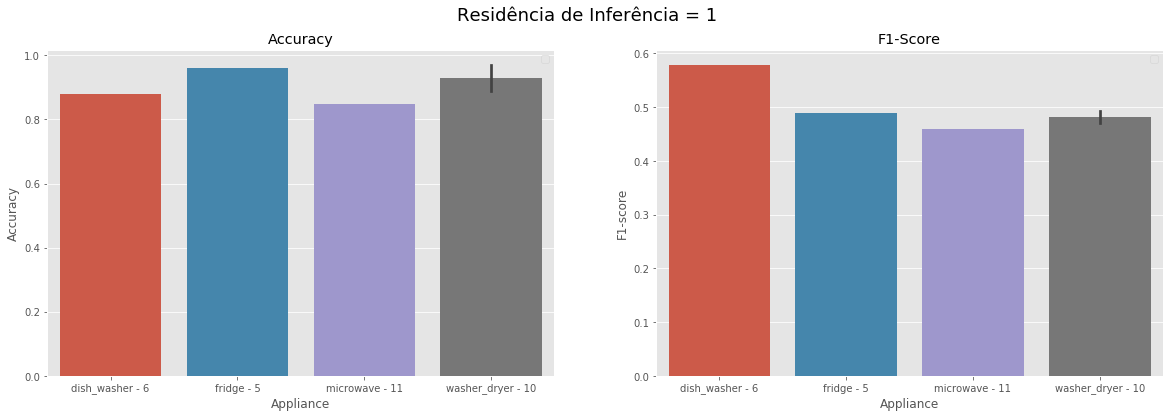

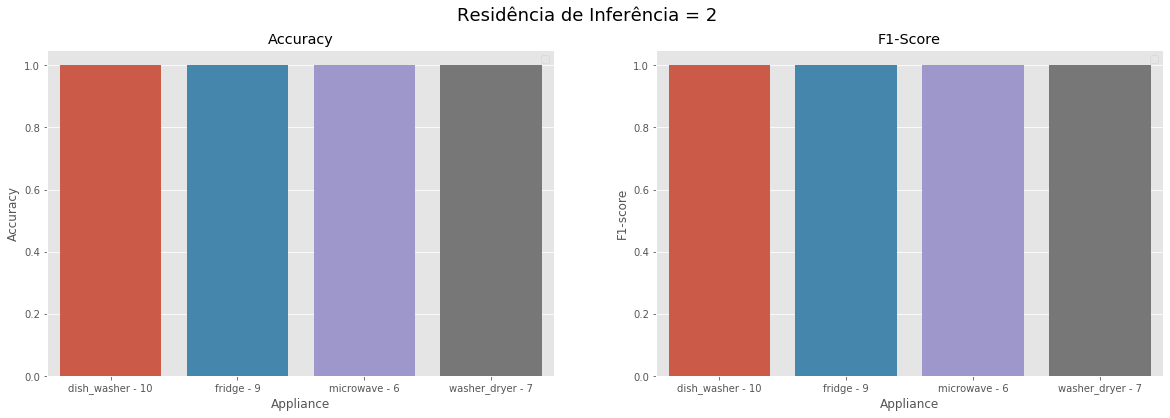

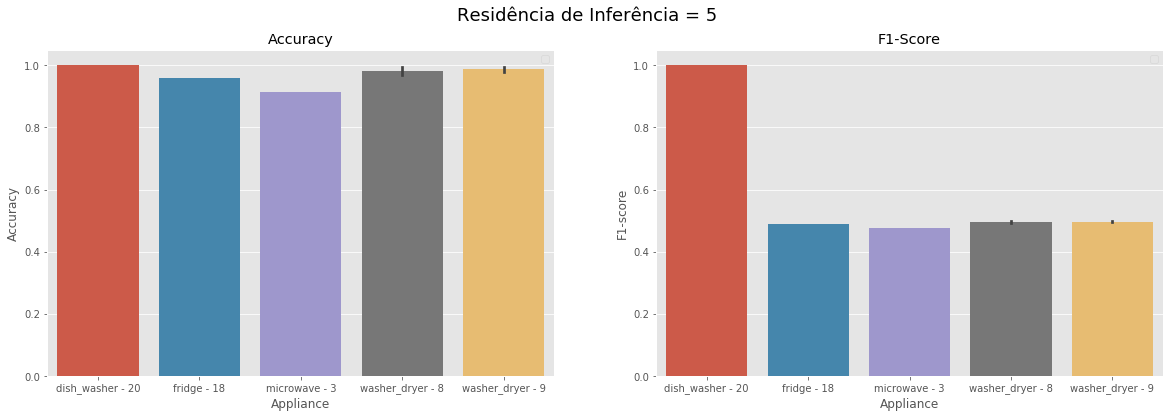

In [114]:
# Lendo resultados
df_generalizacao_superficial = pd.read_excel(
    os.path.join(caminho_dados_notebook, "df_generalizacao_superficial.xlsx"), 
    engine='openpyxl', index_col=[0]
)

for a in df_generalizacao_superficial['house'].unique():
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    df_ = df_generalizacao_superficial.query(f"house=='{a}'").reset_index()

    sns.barplot(x="appliance", y="acc",
                data=df_, ax=axes[0])
    axes[0].set(xlabel='Appliance', ylabel='Accuracy', title=f'Accuracy')
    axes[0].legend([])

    sns.barplot(x="appliance", y="f1",
                data=df_, ax=axes[1])
    axes[1].set(xlabel='Appliance', ylabel='F1-score', title=f'F1-Score')
    axes[1].legend([])

    plt.suptitle(f"Residência de Inferência = {a}", size=18);
    plt.show();
    

## Generalização cruzada

In [ ]:
from sklearn.base import clone
# Avaliar em cada uma das casas similares ao estudo (3)
# Dishwasher     - Casas 1, 2, 4, 5, 6
# Fridge         - Casas 1, 2,    5, 6
# Microwave      - Casas 1, 2,    5
# Washer Dryer 1 - Casas 1, 2, 4, 5, 6 
# Washer Dryer 2 - Casas 1, 2, 4, 5, 6

modelos = {
    'dish_washer': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'fridge': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'microwave': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'washer_dryer': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
}

resultados_generalizacao = {
    "house_train": [], "house_test": [], 
    "appliance": [], 
    "on_train": [], "off_train": [],
    "on_test": [], "off_test": [],
    "acc": [], "f1": [], "auc": []}

RESIDENCIAS = [1,2,3,5]

for RESIDENCIA_TESTE in RESIDENCIAS:
    
    RESIDENCIAS_TREINO = list(set(RESIDENCIAS) - set([RESIDENCIA_TESTE]))
    
    for rotulo_aparelho in df_melhores_taxas_janelas.loc[
        df_melhores_taxas_janelas["carga"].isin([
            'dish_washer - 9','fridge - 7','microwave - 16',
            'washer_dryer - 13','washer_dryer - 14'
        ]), : ]["carga"].values:      
        
        print("="*80)
        print(f"# AVALIANDO GENERALIZAÇÃO CRUZADA: \n" +
              f"  - Aparelho              : {CARGA} (Instância #{INSTANCIA}) \n" +
              f"  - Residências de treino : {RESIDENCIAS_TREINO} \n" +
              f"  - Residência de teste   : {RESIDENCIA_TESTE}")
        print("="*80)
        print()
        
        # Informacoes da carga selecionada (TREINAMENTO)
        CARGA = rotulo_aparelho.split(" - ")[0]
        config_aparelho = df_melhores_taxas_janelas[
            df_melhores_taxas_janelas["carga"]==rotulo_aparelho
        ].to_dict("records")[0]
        TAXA = config_aparelho["taxa_amostragem"]
        TAMANHO_JANELA = config_aparelho["janela"]
        
        # Percorrer instancias do aparelho na residencias
        print("# Preparando dados de treino...")
        X_treino = []
        y_treino = []
        for RESIDENCIA_TREINO in RESIDENCIAS_TREINO:
            print(f"  - Residência: {RESIDENCIA_TREINO}")
            
            for INSTANCIA_TREINO in instancia_aparelho_residencia(
                CARGA, RESIDENCIA_TREINO, base = redd):
                janelas = Janelas(**{
                    "base":redd,
                    "id_residencia": RESIDENCIA_TREINO,
                    "inicio_intervalo": PARAMETROS_DATASET_TREINO['inicio_intervalo'], #'2011-04-16 05:11:30', # MUDANCA
                    "fim_intervalo": PARAMETROS_DATASET_TREINO['fim_intervalo'], #'2011-04-23 08:43:26',
                    "debug": False    
                })

                # Carregando dados de treino
                X, y = carregar_dados_aparelho(
                    janelas=janelas,
                    instancia=INSTANCIA_TREINO,
                    aparelho=CARGA,
                    tamanho_janela=TAMANHO_JANELA,
                    taxa=TAXA,
                    eliminar_janelas_vazias=True
                )
                                
                X_treino.append(X)
                y_treino.append(y)
        
        X_treino = np.concatenate(X_treino, axis=0)
        y_treino = np.concatenate(y_treino, axis=0)
        
        # validar tamanho (limite memoria)
        if X_treino.shape[0] > 5000:
            _, idx = next(StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED).split(X_treino, y_treino))
            X_treino = X_treino[idx]
            y_treino = y_treino[idx]
            
        print("# Conjunto de treino obtido...")
        print(f"   - X: {X_treino.shape}")
        print(f"   - y: {y_treino.shape}")

        # Carregando dados de teste
        janelas = Janelas(**{
            "base":redd,
            "id_residencia": RESIDENCIA_TESTE,
            "inicio_intervalo": PARAMETROS_DATASET_TESTE['inicio_intervalo'],#'2011-04-16 01:11:27', #'2011-04-16 05:11:30', # MUDANCA
            "fim_intervalo": PARAMETROS_DATASET_TESTE['fim_intervalo'], #'2011-04-23 08:43:26',
            "debug": False    
        })
        
        print("# Preparando dados de teste...")
        for INSTANCIA in instancia_aparelho_residencia(
            CARGA, RESIDENCIA_TESTE, base = redd):

            X_teste, y_teste = carregar_dados_aparelho(
                janelas=janelas,
                instancia=INSTANCIA,
                aparelho=CARGA,
                tamanho_janela=TAMANHO_JANELA,
                taxa=TAXA,
                eliminar_janelas_vazias=True
            )
            
            print("     . Detalhes da amostragem (lotes):")
            print("     ---")
            print("     % Treinamento:")
            for item in Counter(y_treino).items():
                print(f"       - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y_treino)*100,1)}%)" )
            print("     % Teste:")
            for item in Counter(y_teste).items():
                print(f"       - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y_teste)*100,1)}%)" )
            print()

            # Treinando modelo
            clf = DLAFE(
                feature_extractor = transfer_learning.vgg16.VGG16(
                    input_shape=TAMANHO_IMAGEM_DLAFE,
                    weights='imagenet', 
                    include_top=False,
                    pooling='avg'
                ),
                preprocess_input = transfer_learning.vgg16.preprocess_input,
                classifier = clone(modelos[CARGA]),
                rp_params = PARAMETROS_RP,
                input_shape = TAMANHO_IMAGEM_DLAFE,
                normalize=False
            )
            clf.fit(X_treino, y_treino)

            # Prevendo conjunto de teste
            print("     . Avaliando modelo...")
            y_hat = clf.predict(X_teste)

            # Incrementando resultados
            acuracia = accuracy_score(y_teste, y_hat)
            f1_macro = f1_score(y_teste, y_hat, average="macro")
            area_curva = roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5
            print("     . Resultados...")
            print(f"        -> Acurácia: {acuracia*100:.2f}%")
            print(f"        -> F1-macro: {f1_macro*100:.2f}%")
            print(f"        -> AUC     : {area_curva}")

            resultados_generalizacao["house_train"].append(RESIDENCIAS_TREINO)
            resultados_generalizacao["house_test"].append(RESIDENCIA_TESTE)
            resultados_generalizacao["appliance"].append(f'{CARGA} - {INSTANCIA}')
            resultados_generalizacao["acc"].append( acuracia )
            resultados_generalizacao["f1"].append( f1_macro )
            resultados_generalizacao["auc"].append( area_curva )
            dist = dict(Counter(y_treino))                        
            resultados_generalizacao["on_train"].append( dist[0] if 0 in dist else 0 )
            resultados_generalizacao["off_train"].append( dist[1] if 1 in dist else 0 )
            dist = dict(Counter(y_teste))                        
            resultados_generalizacao["on_test"].append( dist[0] if 0 in dist else 0 )
            resultados_generalizacao["off_test"].append( dist[1] if 1 in dist else 0 )

            print()
            
# Persistindo resultados
df_generalizacao_cruzada = pd.DataFrame(resultados_generalizacao)
df_generalizacao_cruzada["house_train"] = df_generalizacao_cruzada["house_train"].astype(str)
df_generalizacao_cruzada.to_excel(os.path.join(caminho_dados_notebook, "df_generalizacao_cruzada.xlsx"))

print("############################## FINAL MODEL RESULTS ##############################")
display(df_generalizacao_cruzada.groupby(["house_train","house_test","appliance"]).agg({
    "acc": ["mean", "std", "max", "min"],
    "f1": ["mean", "std", "max", "min"],
    #"auc": ["mean", "std", "max", "min"]
}))

acc                      \
                                              mean       std       max   
house_train house_test appliance                                         
[1, 2, 3]   5          dish_washer - 20   0.986301       NaN  0.986301   
                       fridge - 18        1.000000       NaN  1.000000   
                       microwave - 3      0.793103       NaN  0.793103   
                       washer_dryer - 8   0.983365  0.020213  0.997658   
                       washer_dryer - 9   0.989105  0.013752  0.998829   
[1, 2, 5]   3          dish_washer - 9    0.958333       NaN  0.958333   
                       fridge - 7         0.934307       NaN  0.934307   
                       microwave - 16     0.917178       NaN  0.917178   
                       washer_dryer - 13  0.956486  0.011521  0.964633   
                       washer_dryer - 14  0.946488  0.007819  0.952017   
[1, 3, 5]   2          dish_washer - 10   1.000000       NaN  1.000000   
                       fridge - 9         1.000000       NaN  1.000000   
                       microwave - 6      1.000000       NaN  1.000000   
                       washer_dryer - 7   1.000000  0.000000  1.000000   
[2, 3, 5]   1          dish_washer - 6    0.886957       NaN  0.886957   
                       fridge - 5         0.961039       NaN  0.961039   
                       microwave - 11     0.858696       NaN  0.858696   
                       washer_dryer - 10  0.970678  0.004252  0.973684   

                                                          f1            \
                                               min      mean       std   
house_train house_test appliance                                         
[1, 2, 3]   5          dish_washer - 20   0.986301  0.496552       NaN   
                       fridge - 18        1.000000  1.000000       NaN   
                       microwave - 3      0.793103  0.442308       NaN   
                       washer_dryer - 8   0.969072  0.495780  0.005139   
                       washer_dryer - 9   0.979381  0.497249  0.003476   
[1, 2, 5]   3          dish_washer - 9    0.958333  0.541967       NaN   
                       fridge - 7         0.934307  0.483019       NaN   
                       microwave - 16     0.917178  0.702102       NaN   
                       washer_dryer - 13  0.948339  0.581743  0.046034   
                       washer_dryer - 14  0.940959  0.574255  0.014996   
[1, 3, 5]   2          dish_washer - 10   1.000000  1.000000       NaN   
                       fridge - 9         1.000000  1.000000       NaN   
                       microwave - 6      1.000000  1.000000       NaN   
                       washer_dryer - 7   1.000000  1.000000  0.000000   
[2, 3, 5]   1          dish_washer - 6    0.886957  0.470046       NaN   
                       fridge - 5         0.961039  0.490066       NaN   
                       microwave - 11     0.858696  0.461988       NaN   
                       washer_dryer - 10  0.967671  0.492559  0.001095   

                                                              
                                               max       min  
house_train house_test appliance                              
[1, 2, 3]   5          dish_washer - 20   0.496552  0.496552  
                       fridge - 18        1.000000  1.000000  
                       microwave - 3      0.442308  0.442308  
                       washer_dryer - 8   0.499414  0.492147  
                       washer_dryer - 9   0.499707  0.494792  
[1, 2, 5]   3          dish_washer - 9    0.541967  0.541967  
                       fridge - 7         0.483019  0.483019  
                       microwave - 16     0.702102  0.702102  
                       washer_dryer - 13  0.614294  0.549192  
                       washer_dryer - 14  0.584858  0.563651  
[1, 3, 5]   2          dish_washer - 10   1.000000  1.000000  
                       fridge - 9         1.000000  1.0

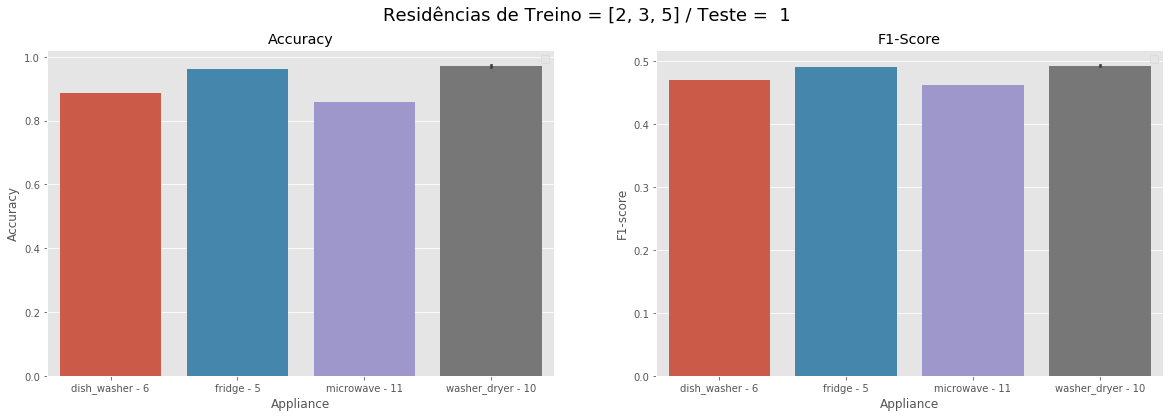

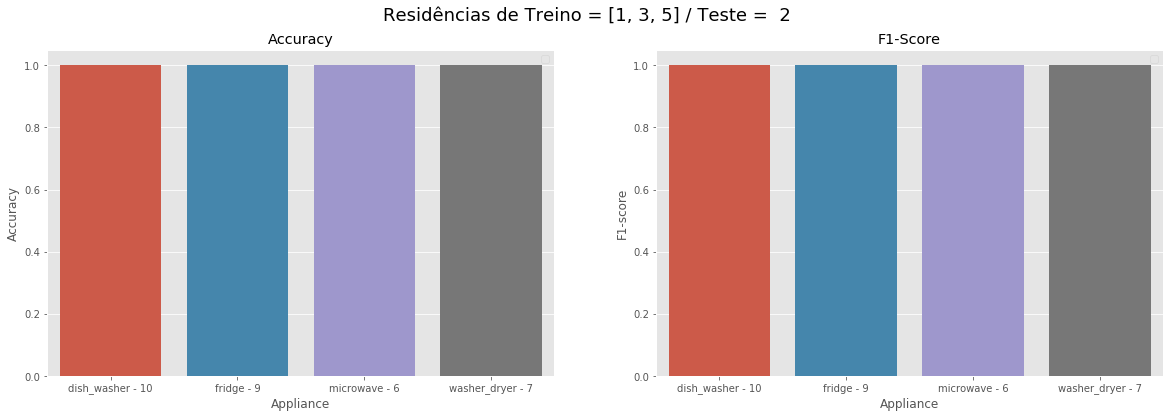

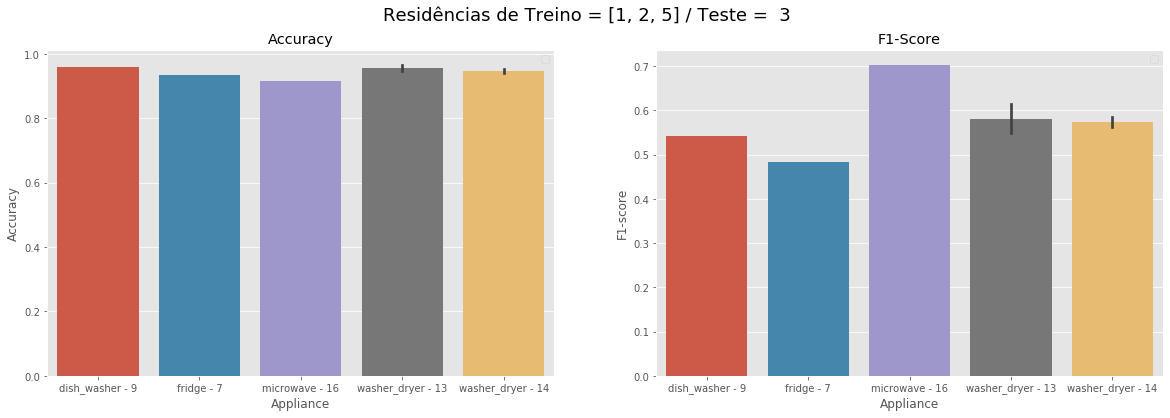

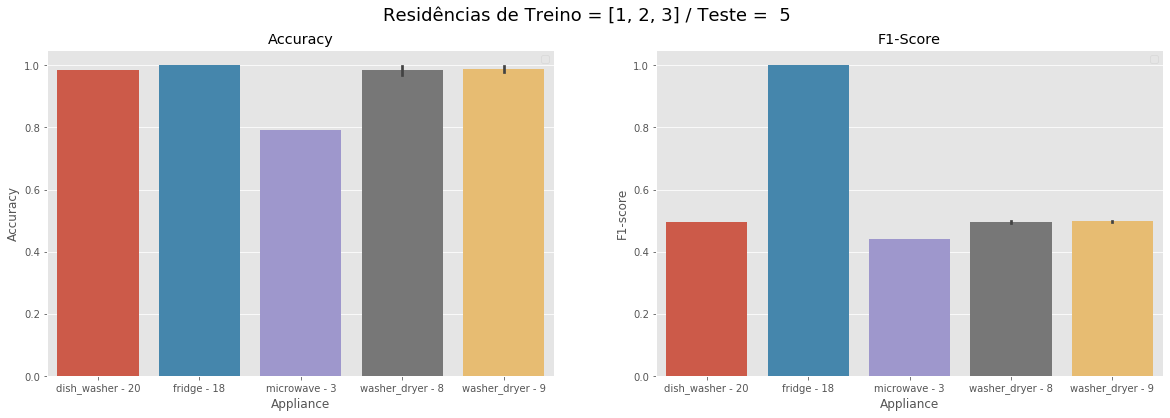

In [115]:
# Lendo resultados
df_generalizacao_cruzada = pd.read_excel(
    os.path.join(caminho_dados_notebook, "df_generalizacao_cruzada.xlsx"), 
    engine='openpyxl', index_col=[0]
)

for a in df_generalizacao_cruzada['house_train'].unique():
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    df_ = df_generalizacao_cruzada.query(f"house_train=='{a}'").reset_index()

    sns.barplot(x="appliance", y="acc",
                data=df_, ax=axes[0])
    axes[0].set(xlabel='Appliance', ylabel='Accuracy', title=f'Accuracy')
    axes[0].legend([])#frameon=False, loc='best', ncol=2); 

    sns.barplot(x="appliance", y="f1",
                data=df_, ax=axes[1])
    axes[1].set(xlabel='Appliance', ylabel='F1-score', title=f'F1-Score')
    axes[1].legend([])#frameon=False, loc='best', ncol=2); 

    resid_treino = [int(a_) for a_ in a.replace('[','').replace(']','').split(', ')]
    resid_teste = list(set([1,2,3,5]) - set(resid_treino))[0]
    plt.suptitle(f"Residências de Treino = {resid_treino} / Teste =  {resid_teste}", size=18);
    plt.show();
    

**CONCLUSÕES PARCIAIS:**
    - Os atributos latentes aprendidos no aparelho `fridge` são intercambiáveis entre as cadas 1, 2 e 5;
    

## Impacto de Diferentes Janelas por Aparelho

In [14]:
# Modelos de classificacao adotados - com base no estudo 24
modelos = {
    'dish_washer - 9': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'fridge - 7': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'microwave - 16': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'washer_dryer - 13': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
    'washer_dryer - 14': MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED),
}

resultados_modelo = {
    "appliance": [], "fold": [],
    "acc": [], "f1": [], "auc": [], 
    "base": [], "window_length": [],
}

# Intervalo fixo para todos aparelhos
janelas = [30, 60, 90, 180, 360, 540, 720, 900, 1080, 2040]
# janelas = {
#     'dish_washer - 9': [720, 900, 1080, 2040],
#     'fridge - 7': [720, 900, 1080, 2040],
#     'microwave - 16': [30, 60, 90, 180],
#     'washer_dryer - 13': [30, 60, 90, 180, 360, 540, 720, 900, 1080, 2040],
#     'washer_dryer - 14': [30, 60, 90, 180, 360, 540, 720, 900, 1080, 2040],
# }

# Carregando dados de treino/teste
janelas_treino = Janelas(**PARAMETROS_DATASET_TREINO)
janelas_teste = Janelas(**PARAMETROS_DATASET_TESTE)

# Processamento de cada aparelho
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        [
            'dish_washer - 9','fridge - 7','microwave - 16',
            'washer_dryer - 13', 'washer_dryer - 14'
        ]),
    : ]["carga"].values:
    
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    for TAMANHO_JANELA in janelas:#[rotulo_aparelho]:
        
        print(f" . TAMANHO_JANELA = {TAMANHO_JANELA}...\n")
        
        # Informacoes da carga selecionada
        CARGA = rotulo_aparelho.split(" - ")[0]
        INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

        config_aparelho = df_melhores_taxas_janelas[
            df_melhores_taxas_janelas["carga"]==rotulo_aparelho
        ].to_dict("records")[0]
        #TAMANHO_JANELA = config_aparelho["janela"]
        TAXA = config_aparelho["taxa_amostragem"]

        #######################################################################
        #                AVALIACAO 1 - Base de treino / CV                    #
        #######################################################################
        # Extrair series divididas em janelas para cada medidor
        print("   - Base de TREINO\n")
        print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas_treino,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print("     -> Detalhes da amostragem (lotes):")
        print("     ---")
        for item in Counter(y).items():
            print(f"        - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
        print()

        y_true, y_pred  = [], []

        print(f"     -> Avaliando modelo (CV - {skf.n_splits} folds)...\n")
        for it, (idx_treino, idx_teste) in tqdm_notebook(enumerate(skf.split(X, y)), total=skf.n_splits):

            # Preparando lotes
            X_treino, X_teste = X[idx_treino], X[idx_teste]
            y_treino, y_teste = y[idx_treino], y[idx_teste]

            # Treinando modelo
            reset_tf_session(model_name='dlafe')
            dlafe = DLAFE(
                feature_extractor = transfer_learning.vgg16.VGG16(
                    input_shape=TAMANHO_IMAGEM_DLAFE,
                    weights='imagenet', 
                    include_top=False,
                    pooling='avg'
                ),
                preprocess_input = transfer_learning.vgg16.preprocess_input,
                classifier = clone(modelos[rotulo_aparelho]),
                rp_params = PARAMETROS_RP,
                input_shape = TAMANHO_IMAGEM_DLAFE,
                normalize=False
            )
            dlafe.fit(X_treino, y_treino)

            # Prevendo conjunto de teste
            y_hat = dlafe.predict(X_teste)

            # Incrementando resultados
            resultados_modelo["appliance"].append(rotulo_aparelho)
            resultados_modelo["fold"].append(it+1)
            resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
            resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
            resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)
            resultados_modelo["base"].append("treino")
            resultados_modelo["window_length"].append(TAMANHO_JANELA)

            # Extendendo rotulos (analise global)
            y_true.extend(y_teste)
            y_pred.extend(y_hat)

    #         print(f"       _ Classification Report fold #{it}:")
    #         print()
    #         print(classification_report(y_teste, y_hat))

        #######################################################################
        #                 AVALIACAO 2 - Base de teste / CV                    #
        #######################################################################
        print("   - Base de TESTE\n")
        print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))

        # Avaliar na base de teste
        X_teste, y_teste = carregar_dados_aparelho(
            janelas=janelas_teste,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )

        print("     -> Detalhes da amostragem (lotes):")
        print("     ---")
        for item in Counter(y_teste).items():
            print(f"       - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y_teste)*100,1)}%)" )
        print()


        # Treinando modelo
        reset_tf_session(model_name='dlafe')
        dlafe = DLAFE(
            feature_extractor = transfer_learning.vgg16.VGG16(
                input_shape=TAMANHO_IMAGEM_DLAFE,
                weights='imagenet', 
                include_top=False,
                pooling='avg'
            ),
            preprocess_input = transfer_learning.vgg16.preprocess_input,
            classifier = clone(modelos[rotulo_aparelho]),
            rp_params = PARAMETROS_RP,
            input_shape = TAMANHO_IMAGEM_DLAFE,
            normalize=False
        )
        dlafe.fit(X, y)

        # Prevendo conjunto de teste
        y_hat = dlafe.predict(X_teste)

        # Incrementando resultados
        resultados_modelo["appliance"].append(rotulo_aparelho)
        resultados_modelo["fold"].append(it+1)
        resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
        resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
        resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)
        resultados_modelo["base"].append("teste")
        resultados_modelo["window_length"].append(TAMANHO_JANELA)

        print()
        print("   - Final Results:")
        print("   ---")
        print()

        print("      -> Classification Report:")
        print()
        print(classification_report(y_true, y_pred))
        print("      -> Confusion Matrix:")
        print()
        print(confusion_matrix(y_true, y_pred))

    print()
    
# Consolidating DataFrame
df_resultados_janelas = pd.DataFrame(resultados_modelo)
df_resultados_janelas.to_excel(os.path.join(caminho_dados_notebook, "df_resultados_janelas.xlsx"))
    
print("############################## FINAL MODEL RESULTS ##############################")
display(df_resultados_janelas.groupby(["appliance","window_length","base"]).agg({
    "acc": ["mean", "std", "max", "min"],
    "f1": ["mean", "std", "max", "min"],
    "auc": ["mean", "std", "max", "min"]
}))

* Aparelho DISH_WASHER - 9:

 . TAMANHO_JANELA = 30...

   - Base de TREINO

     -> Carregando dados (taxa=2, janela=30)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
        - Classe `0`: 9534 amostras (98.6%)
        - Classe `1`: 131 amostras (1.4%)

     -> Avaliando modelo (CV - 10 folds)...



  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
0
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10602
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas /

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPU

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPU

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10354
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10617
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10610
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10618
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10624
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
8683
Inicializando sessão com 1 GPUs Físicas / 1 GP

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10625
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10619
Inicializando sessão com 1 GPUs Física

  0%|          | 0/10 [00:00<?, ?it/s]

* Reinicializando sessão tensorflow...
6738
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Físicas / 1 GPUs Lógicas
* Reinicializando sessão tensorflow...
10611
Inicializando sessão com 1 GPUs Física

acc                      \
                                            mean       std       max   
appliance         window_length base                                   
dish_washer - 9   30            teste   0.995344       NaN  0.995344   
                                treino  0.984067  0.002847  0.988613   
                  60            teste   0.998966       NaN  0.998966   
                                treino  0.984902  0.002591  0.987603   
                  90            teste   0.998450       NaN  0.998450   
...                                          ...       ...       ...   
washer_dryer - 14 900           treino  0.963636  0.035855  1.000000   
                  1080          teste   0.994536       NaN  0.994536   
                                treino  0.939474  0.061211  1.000000   
                  2040          teste   1.000000       NaN  1.000000   
                                treino  0.930000  0.067495  1.000000   

                                                        f1            \
                                             min      mean       std   
appliance         window_length base                                   
dish_washer - 9   30            teste   0.995344  0.903885       NaN   
                                treino  0.979317  0.619045  0.064149   
                  60            teste   0.998966  0.981219       NaN   
                                treino  0.981366  0.652801  0.050097   
                  90            teste   0.998450  0.973291       NaN   
...                                          ...       ...       ...   
washer_dryer - 14 900           treino  0.909091  0.823693  0.201626   
                  1080          teste   0.994536  0.982378       NaN   
                                treino  0.777778  0.747586  0.203221   
                  2040          teste   1.000000  1.000000       NaN   
                                treino  0.800000  0.819656  0.209106   

                                                                 auc  \
                                             max       min      mean   
appliance         window_length base                                   
dish_washer - 9   30            teste   0.903885  0.903885  0.865888   
                                treino  0.707651  0.495825  0.596606   
                  60            teste   0.981219  0.981219  0.970910   
                                treino  0.727104  0.586197  0.620416   
                  90            teste   0.973291  0.973291  0.950000   
...                                          ...       ...       ...   
washer_dryer - 14 900           treino  1.000000  0.476190  0.845238   
                  1080          teste   0.982378  0.982378  0.968750   
                                treino  1.000000  0.485714  0.781434   
                  2040          teste   1.000000  1.000000  1.000000   
                                treino  1.000000  0.444444  0.852083   

                                                                      
                                             std       max       min  
appliance         window_length base                                  
dish_washer - 9   30            teste        NaN  0.865888  0.865888  
                                treino  0.051524  0.652797  0.498426  
                  60            teste        NaN  0.970910  0.970910  
                                treino  0.046786  0.711141  0.568277  
                  90            teste        NaN  0.950000  0.950000  
...                                          ...       ...       ...  
washer_dryer - 14 900           treino  0.207263  1.000000  0.500000  
                  1080          teste        NaN  0.968750  0.968750  
                                treino  0.214672  1.000000  0.500000  
                  2040          teste        NaN  1.000000  1.000000  
                                treino  0.214068  1.000000  0.444444  

[100 rows x 12 columns]

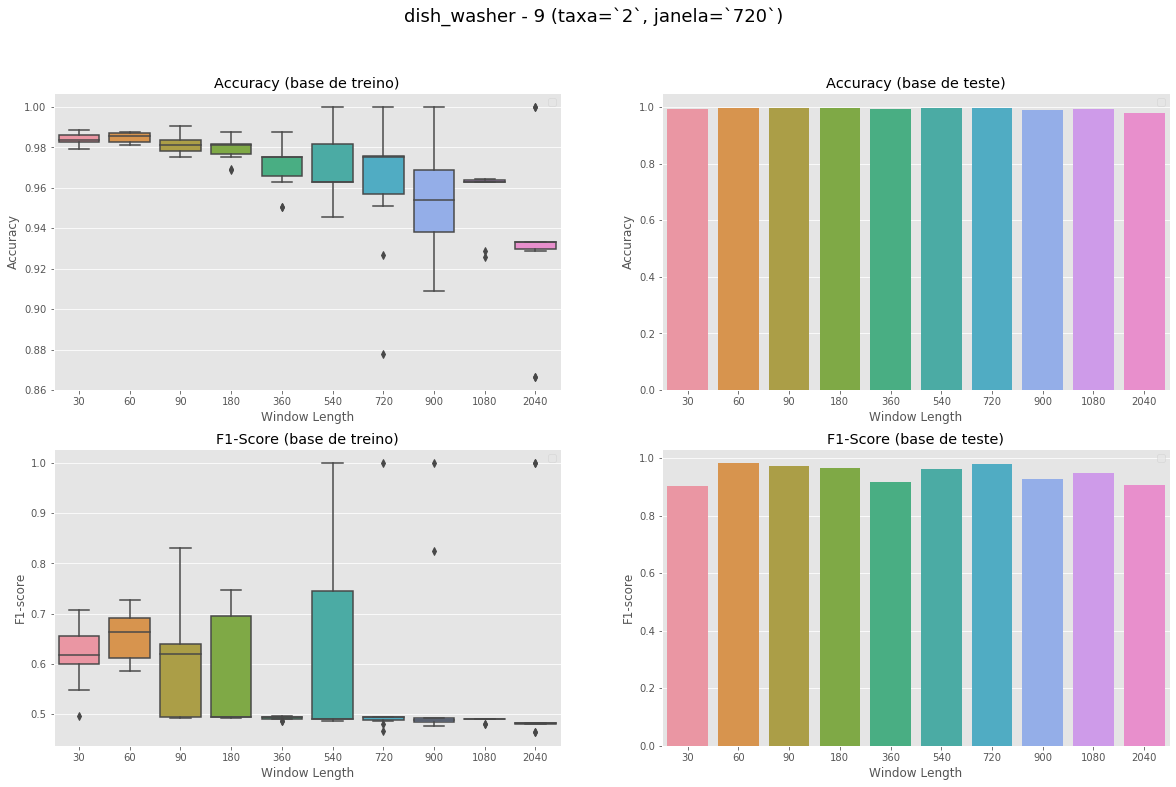

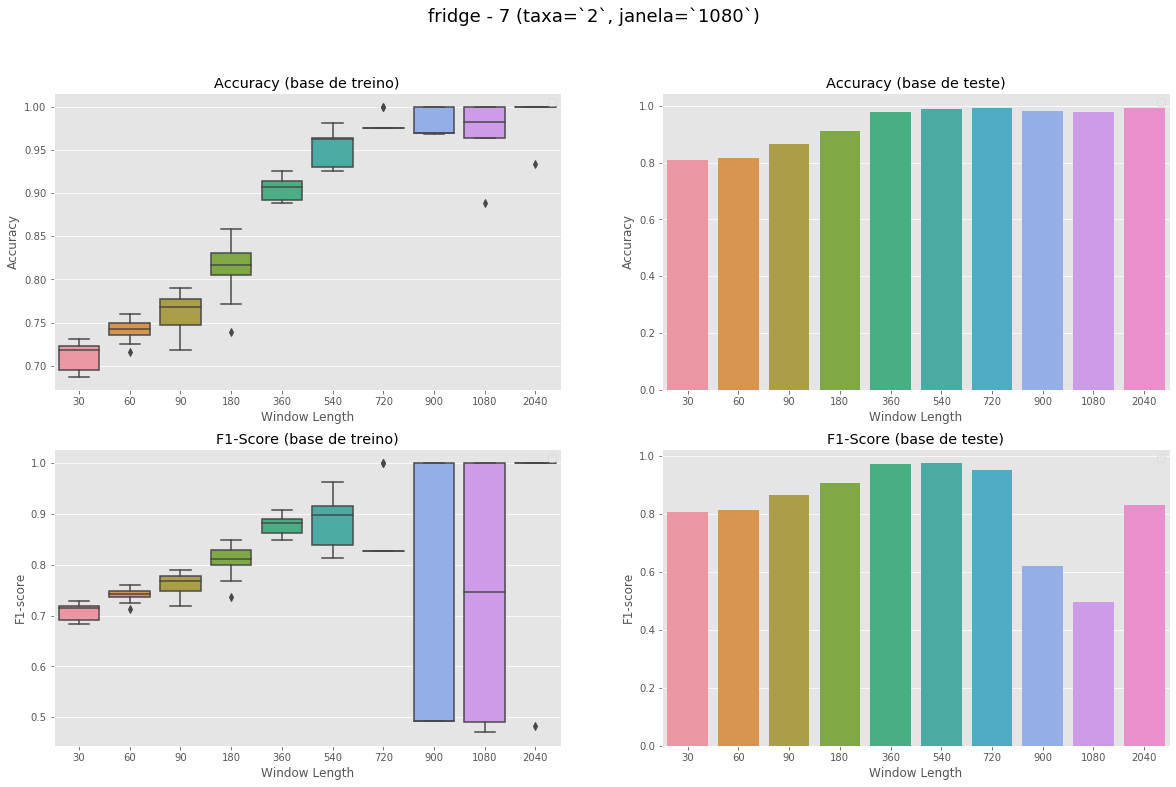

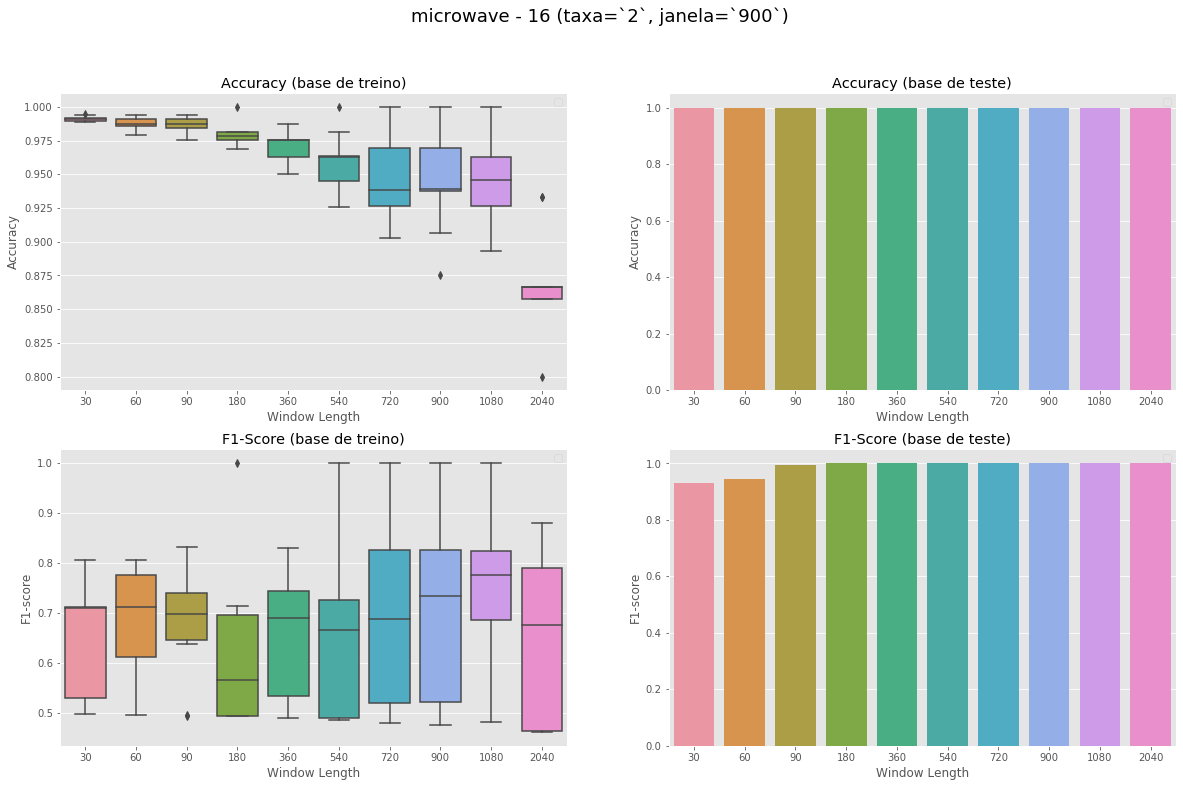

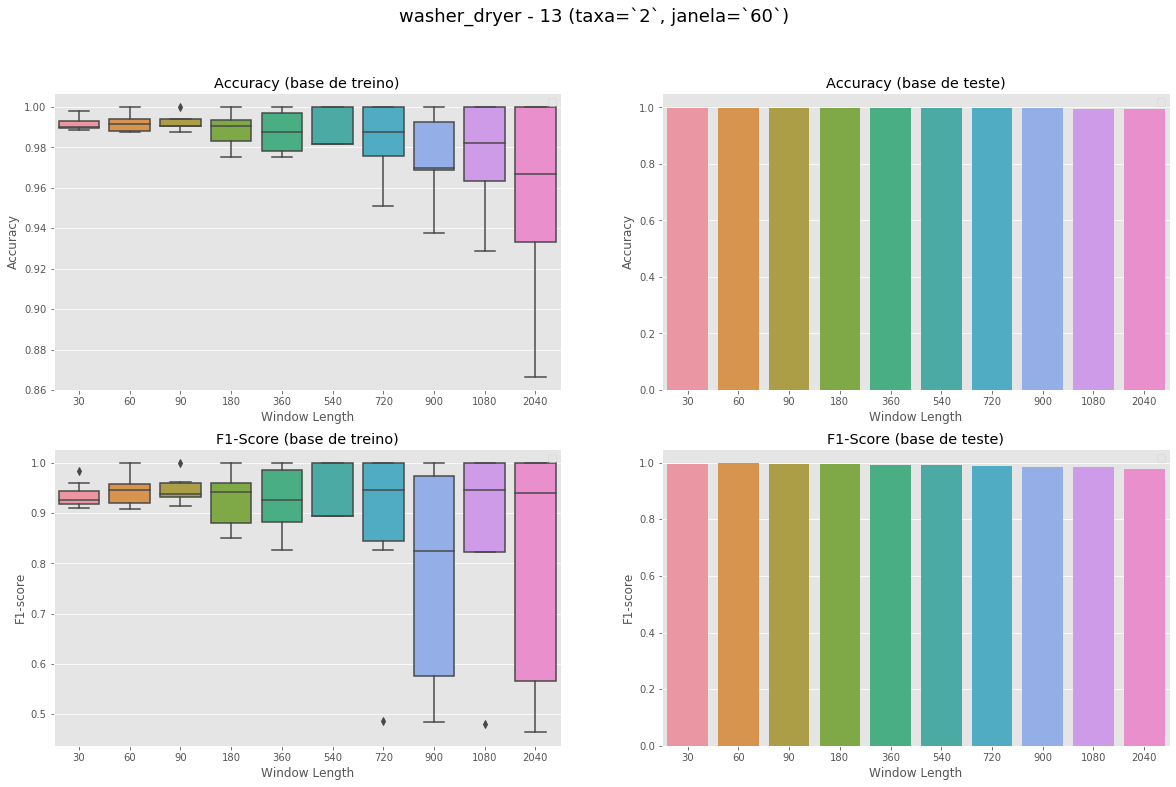

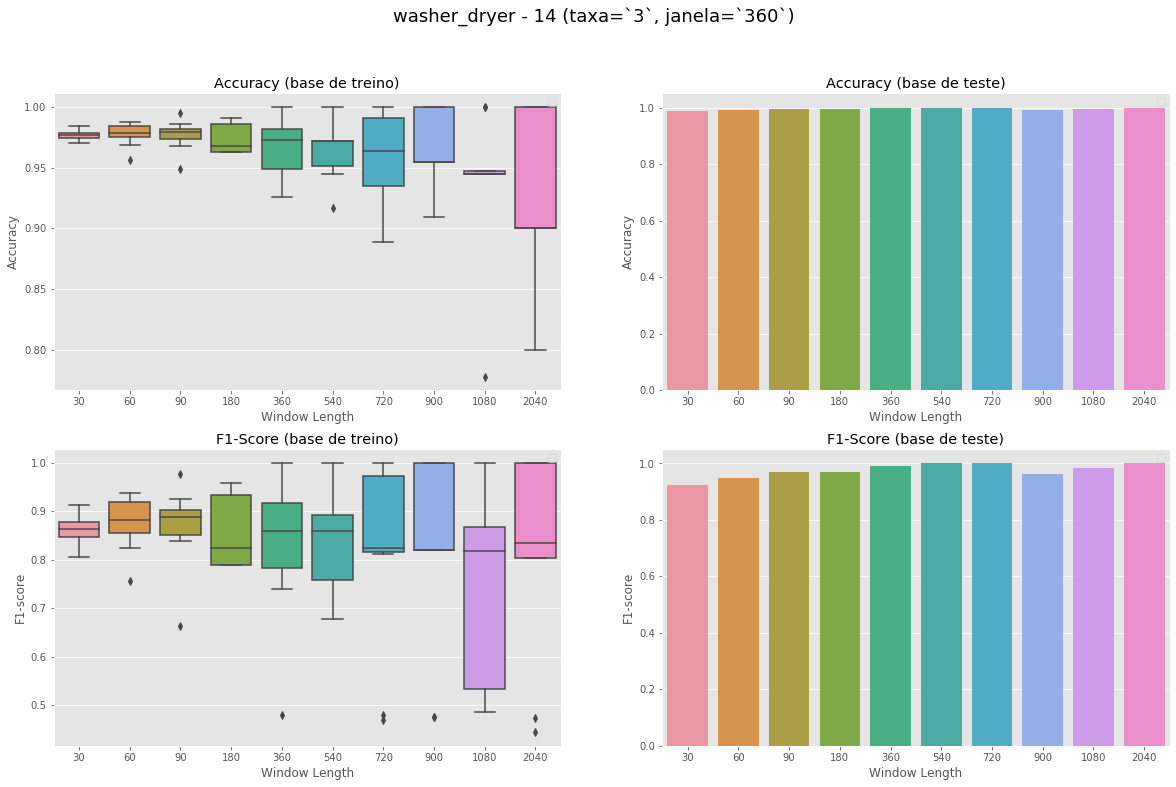

In [67]:
# Lendo resultados
df_resultados_janelas = pd.read_excel(
    os.path.join(caminho_dados_notebook, "df_resultados_janelas.xlsx"), 
    engine='openpyxl'
)

for a in df_resultados_janelas['appliance'].unique():
    
    # Dados base do aparelho
    config_aparelho = df_melhores_taxas_janelas[
            df_melhores_taxas_janelas["carga"]==a
        ].to_dict("records")[0]
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    for i, b in enumerate(['treino','teste']):
        
        df_ = df_resultados_janelas.query(f"appliance == '{a}' and base == '{b}'").reset_index()

        if b == 'treino':
            sns.boxplot(x="window_length", y="acc", #hue="window_length", 
                        data=df_, 
                        ax=axes[0][i]);
            sns.boxplot(x="window_length", y="f1", #hue="window_length", 
                        data=df_, 
                        ax=axes[1][i]);
        else:
            sns.barplot(x="window_length", y="acc", #hue="window_length", 
                        data=df_, 
                        ax=axes[0][i]);
            sns.barplot(x="window_length", y="f1", #hue="window_length", 
                        data=df_, 
                        ax=axes[1][i]);

        axes[0][i].set(xlabel='Window Length', ylabel='Accuracy', title=f'Accuracy (base de {b})')
        axes[1][i].set(xlabel='Window Length', ylabel='F1-score', title=f'F1-Score (base de {b})')
        
        axes[0][i].legend([])
        axes[1][i].legend([])
        
        plt.suptitle(f"{a} (taxa=`{config_aparelho['taxa_amostragem']}`, janela=`{config_aparelho['janela']}`)", size=18);
    
    plt.show();
    

## Aparelhos complexos (EM DESENVOLVIMENTO
---
Divididos em 3 categorias: longo tempo de transitório de ativação / alta flutuação de operação / aparelhos com sobreposição de transitórios

## Outras propostas (EM DESENVOLVIMENTO)

### Separabilidade DLAFE

In [ ]:
# https://towardsdatascience.com/dimensionality-reduction-in-hyperspectral-images-using-python-611b40b6accc

In [ ]:
recurrence_plots = []
dlafe_vectors = []
labels_status = []
labels_appliance = []

for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16',
        'washer_dryer - 13', 'washer_dryer - 14'
        ]),
    : ]["carga"].values:
    
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAMANHO_JANELA = config_aparelho["janela"]
    TAXA = config_aparelho["taxa_amostragem"]
    CONFIG_RP_APARELHO = PARAMETROS_RP
    
    # Percorrer instancias do aparelho na residencia
#     for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):
        
    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X_rp, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    print("   - Detalhes da amostragem (lotes):")
    print("   ---")
    for item in Counter(y).items():
        print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()

    print("* Convertendo séries para RPs...")
    #rqa.extend( preparar_amostras(X, y, rotulo_aparelho) )
    X_rp, y = preparar_amostras(
        X_rp, y, 
        params_rp=PARAMETROS_RP,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    #print(X.shape)

    # Extrair atributos usando Deep/Tranfer Learning
    X_dlafe = extrair_atributos_dl(
        X_rp, 
        modelo=modelo_extrator,
        preprocessamento=preprocess_extrator
    )
    
    recurrence_plots.append(X_rp)
    dlafe_vectors.append(X_dlafe)
    labels_status.append(y)
    labels_appliance.append([rotulo_aparelho for _ in range(len(y))])

In [ ]:
recurrence_plots = np.concatenate(recurrence_plots)
dlafe_vectors = np.concatenate(dlafe_vectors)
labels_status = np.concatenate(labels_status, axis=0)
labels_appliance = np.concatenate(labels_appliance, axis=0)

In [ ]:
import plotly.express as px
import seaborn  as sns
from sklearn.manifold import TSNE

In [ ]:
rp_tsne = TSNE(n_components=3).fit_transform(
    recurrence_plots[:,:,:,0].reshape(-1, TAMANHO_IMAGEM[0]*TAMANHO_IMAGEM[1])
)

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=rp_tsne[:,0], y=rp_tsne[:,1],
    hue=labels_appliance,
    legend="full",
    alpha=0.3
)

In [ ]:
cdict = {'dish_washer - 9': 'green','fridge - 7':'blue','microwave - 16':'red',
        'washer_dryer - 13':'gray', 'washer_dryer - 14':'black'}

fig = px.scatter_3d(
    x=rp_tsne[:,0], 
    y=rp_tsne[:,1], 
    z=rp_tsne[:,2],
    color=labels_appliance
)
fig.show()

In [ ]:
dlafe_tsne = TSNE(n_components=3,n_iter=10000,random_state=SEED).fit_transform(dlafe_vectors)

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=dlafe_tsne[:,0], y=dlafe_tsne[:,1],
    hue=labels_appliance,
    legend="full",
    alpha=0.3
)

In [ ]:
cdict = {'dish_washer - 9': 'green','fridge - 7':'blue','microwave - 16':'red',
        'washer_dryer - 13':'gray', 'washer_dryer - 14':'black'}

fig = px.scatter_3d(
    x=dlafe_tsne[:,0], 
    y=dlafe_tsne[:,1], 
    z=dlafe_tsne[:,2],
    color=labels_appliance
)
fig.show()

### Tentativas de Melhoria
---

CLF / Acc. / F1-Score <br>
Dishwasher      SVM  98.0  64.5<br>
Fridge          MLP 100.01 00.0<br>
Microwave       MLP  96.77 79.1 <br>
Washer Dryer 1  SVM  98.27 79.6<br>
Washer Dryer 2  SVM  98.27 79.6<br>

# Conclusões

...

# Fim.

In [1]:
%load_ext watermark

In [2]:
%watermark -a "Diego Luiz Cavalca" -u -n -t -z -v -m -g

Diego Luiz Cavalca 
last updated: Sat Sep 05 2020 17:08:48 Hora oficial do Brasil 

CPython 3.7.8
IPython 7.17.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : 5725caa95e9d7f4b19a57eff5b998f1738bc40b4
